### Environment Set Up

INSTALL

In [ ]:
!pip install googletrans
!pip install tslearn
!pip install sklearn

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 6.5 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-3.0.0-py3-none-any.whl size=15716 sha256=6931f1092709994b39faf0e06d48d1a9a82c1e60578cc5689bdabc733ed63c39
  Stored in directory: /root/.cache/pip/wheels/b3/81/ea/8b030407f8ebfc2f857814e086bb22ca2d4fea1a7be63652ab
Successfully built googletrans
  Attempting uninstall: chardet
    Found existing installation: chardet 5.2.0
    Uninstalling cha

IMPORT

In [ ]:
import json
import nltk
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from nltk.corpus import stopwords
from googletrans import Translator
from nltk.tokenize import word_tokenize
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

OTHER

In [ ]:
nltk.download("punkt")
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

### Dataset Set Up

In [ ]:
# Kaggle -> Setting -> API -> Upload 'kaggle.json'
!gdown 'https://drive.google.com/uc?id=1lBmRzfsf4rui6bKc8LJUPP-pAr0wQAnK' --output kaggle.json

Downloading...
From: https://drive.google.com/uc?id=1lBmRzfsf4rui6bKc8LJUPP-pAr0wQAnK
To: /content/kaggle.json
100% 66.0/66.0 [00:00<00:00, 425kB/s]


In [ ]:
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
'''
!mkdir old_dataset
%cd old_dataset
!kaggle datasets download -d datasnaek/youtube-new
!unzip youtube-new.zip
%cd ..
'''

'\n!mkdir old_dataset\n%cd old_dataset\n!kaggle datasets download -d datasnaek/youtube-new\n!unzip youtube-new.zip\n%cd ..\n'

In [ ]:
!mkdir new_dataset
%cd new_dataset
!kaggle datasets download -d rsrishav/youtube-trending-video-dataset
!unzip youtube-trending-video-dataset.zip
%cd ..

/content/new_dataset
100% 1.47G/1.48G [00:17<00:00, 106MB/s]
100% 1.48G/1.48G [00:17<00:00, 90.8MB/s]
Archive:  youtube-trending-video-dataset.zip
  inflating: BR_category_id.json     
  inflating: BR_youtube_trending_data.csv  
  inflating: CA_category_id.json     
  inflating: CA_youtube_trending_data.csv  
  inflating: DE_category_id.json     
  inflating: DE_youtube_trending_data.csv  
  inflating: FR_category_id.json     
  inflating: FR_youtube_trending_data.csv  
  inflating: GB_category_id.json     
  inflating: GB_youtube_trending_data.csv  
  inflating: IN_category_id.json     
  inflating: IN_youtube_trending_data.csv  
  inflating: JP_category_id.json     
  inflating: JP_youtube_trending_data.csv  
  inflating: KR_category_id.json     
  inflating: KR_youtube_trending_data.csv  
  inflating: MX_category_id.json     
  inflating: MX_youtube_trending_data.csv  
  inflating: RU_category_id.json     
  inflating: RU_youtube_trending_data.csv  
  inflating: US_category_id.json 

### Pre-Process

#### Set Up Stopwords

In [ ]:
!gdown 'https://drive.google.com/uc?id=1o1C8DpOIcHahdZrtRm3iyRGg9zeTuSxv' --output stopwords.txt

Downloading...
From: https://drive.google.com/uc?id=1o1C8DpOIcHahdZrtRm3iyRGg9zeTuSxv
To: /content/stopwords.txt
100% 4.87k/4.87k [00:00<00:00, 18.4MB/s]


#### Tokenizer

In [ ]:
class Tokenizer:
    def __init__(self) -> None:
        with open("stopwords.txt") as f:
            custom_stopwords = [line.strip() for line in f]
        self.all_stopwords = set(stopwords.words("english")).union(set(custom_stopwords))

    def tokenize_text(self, text):
        '''
        Tokenize title or description
        '''
        if isinstance(text, str):  # Check if the input is a string
            tokens = word_tokenize(text.lower())
            return [x for x in tokens if x not in self.all_stopwords and len(x) > 1]
        else:
            return []  # Return an empty list for non-string inputs

    def tokenize_tag(self, tag_str):
        '''
        Tokenize tags string e.g. "cgpgrey|education|hello internet"
        '''
        if len(tag_str) > 0 and tag_str != "[None]":
            return [x.strip() for x in tag_str.split("|")]
        else:
            return []

#### Translator

In [ ]:
translator = Translator()

#### Category Json Loader

In [ ]:
def category_loader(json_path):
    with open(json_path, "r") as file:
        data = json.load(file)
    json_data = pd.json_normalize(data)
    data_list = []
    for item in json_data["items"][0]:
        data_dict = {
          "id": item['id'],
          "category": item['snippet']['title'],
        }
        data_list.append(data_dict)
    df = pd.DataFrame(data_list)
    return df

#### Video Data Regularizer

In [ ]:
USEFUL_COLS = [
    'video_id',
    'title',
    'publishedAt',
    'categoryId',
    'trending_date',
    'tags',
    'view_count',
    'likes',
    'dislikes',
    'comment_count',
    'description'
]

In [ ]:
TOKEN_COLS = [
    'title',
    'tags',
    'description'
]

In [ ]:
def videoDataRegularizer(video_df, cols=USEFUL_COLS, token=True):
    df = video_df[cols].copy()

    if token:
      tokenizer = Tokenizer()
      #df['title'] = df['title'].apply(tokenizer.tokenize_text)
      df['tags'] = df['tags'].apply(tokenizer.tokenize_tag)
      #df['description'] = df['description'].apply(tokenizer.tokenize_text)

    df['publishedAt'] = pd.to_datetime(df['publishedAt'])
    df['trending_date'] = pd.to_datetime(df['trending_date'])
    return df

#### Combine Video Data & Categories

In [ ]:
def combineData(df1, df2):
    df1['categoryId'] = df1['categoryId'].astype(str)
    df2['id'] = df2['id'].astype(str)
    df = df1.merge(df2, left_on='categoryId', right_on='id', how='left')
    df = df.drop(columns=['categoryId', 'id'])
    return df

### Analysis

In [ ]:
canada_videos = videoDataRegularizer(pd.read_csv('/content/new_dataset/CA_youtube_trending_data.csv'))
canada_cid = category_loader('/content/new_dataset/CA_category_id.json')
canada_data = combineData(canada_videos,canada_cid)

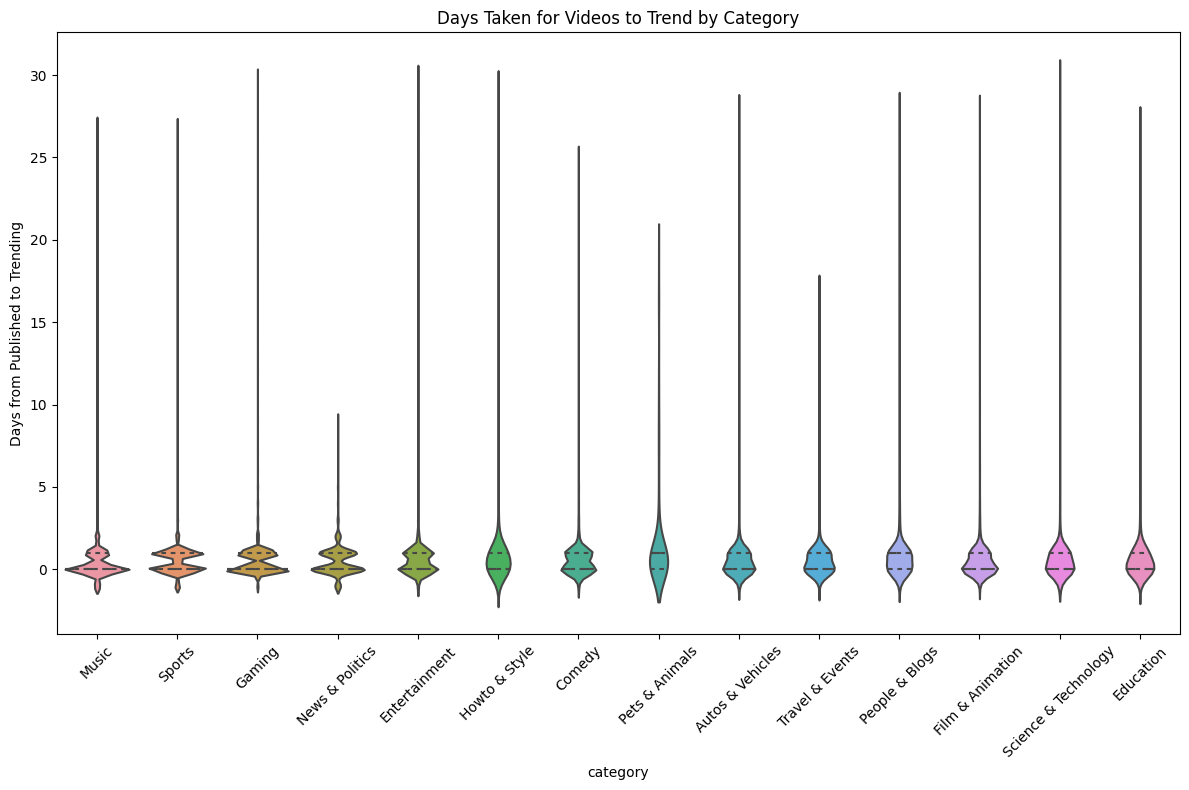

In [ ]:
canada_data['time_to_trend'] = (canada_data['trending_date'] - canada_data['publishedAt']).dt.days

# 由于一个video_id可能有多条记录，我们只保留第一次出现的那条，即首次成为趋势的记录
first_trend = canada_data.sort_values('trending_date').drop_duplicates('video_id')

# 使用Seaborn库的箱线图或小提琴图进行绘制
plt.figure(figsize=(12, 8))
sns.violinplot(data=first_trend, x='category', y='time_to_trend', inner="quartile")
plt.xticks(rotation=45)
plt.ylabel('Days from Published to Trending')
plt.title('Days Taken for Videos to Trend by Category')
plt.tight_layout()
plt.show()

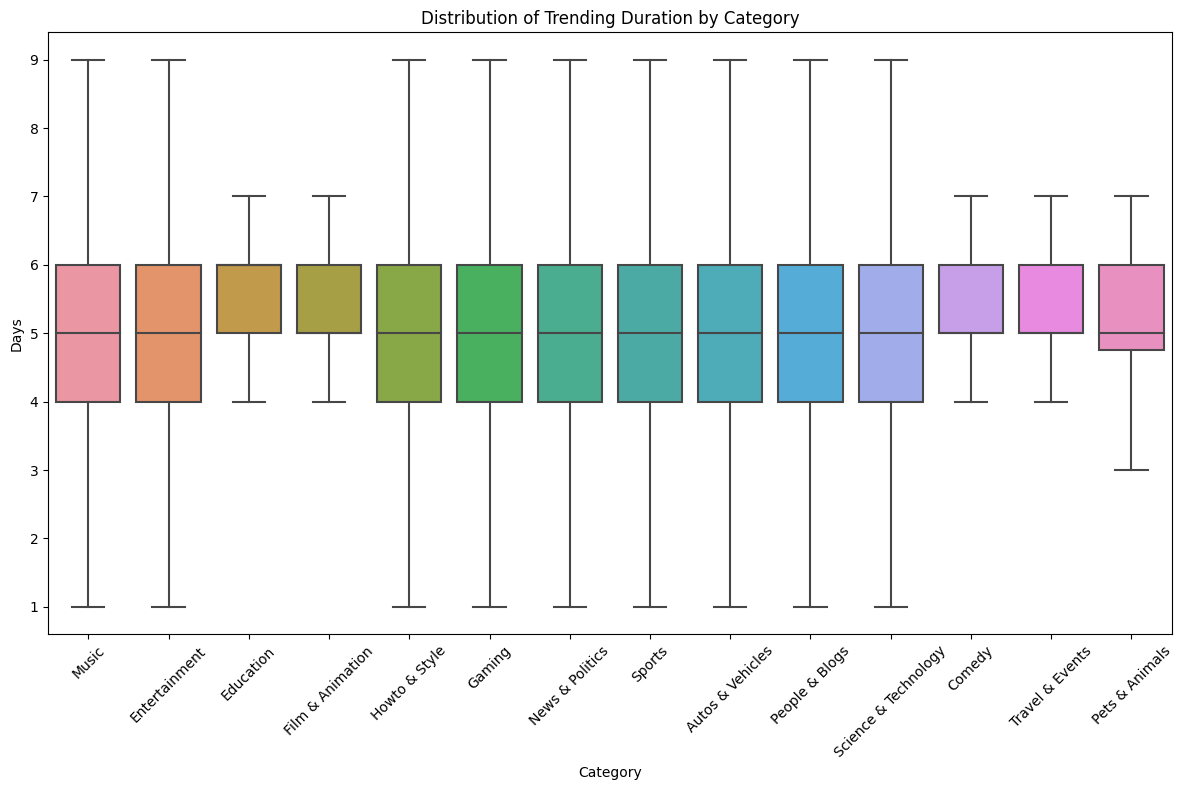

In [ ]:
df_group = canada_data.groupby("video_id").agg(
    start_trending=pd.NamedAgg(column="trending_date", aggfunc="min"),
    end_trending=pd.NamedAgg(column="trending_date", aggfunc="max"),
    category=pd.NamedAgg(column="category", aggfunc="first") # 我们假设一个video_id对应的category是不变的
)

# 计算trending的时长
df_group["trending_duration"] = (df_group["end_trending"] - df_group["start_trending"]).dt.days + 1

# 绘制boxplot
plt.figure(figsize=(12, 8))
sns.boxplot(x="category", y="trending_duration", data=df_group, showfliers=False) # showfliers=False会忽略异常值
plt.xlabel("Category")
plt.ylabel("Days")
plt.title("Distribution of Trending Duration by Category")
plt.xticks(rotation=45) # 如果category的名字太长，可以旋转标签使其更易读
plt.tight_layout()
plt.show()

<ipython-input-21-496c0f1f048b>:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  canada_data['month'] = canada_data['publishedAt'].dt.to_period('M')


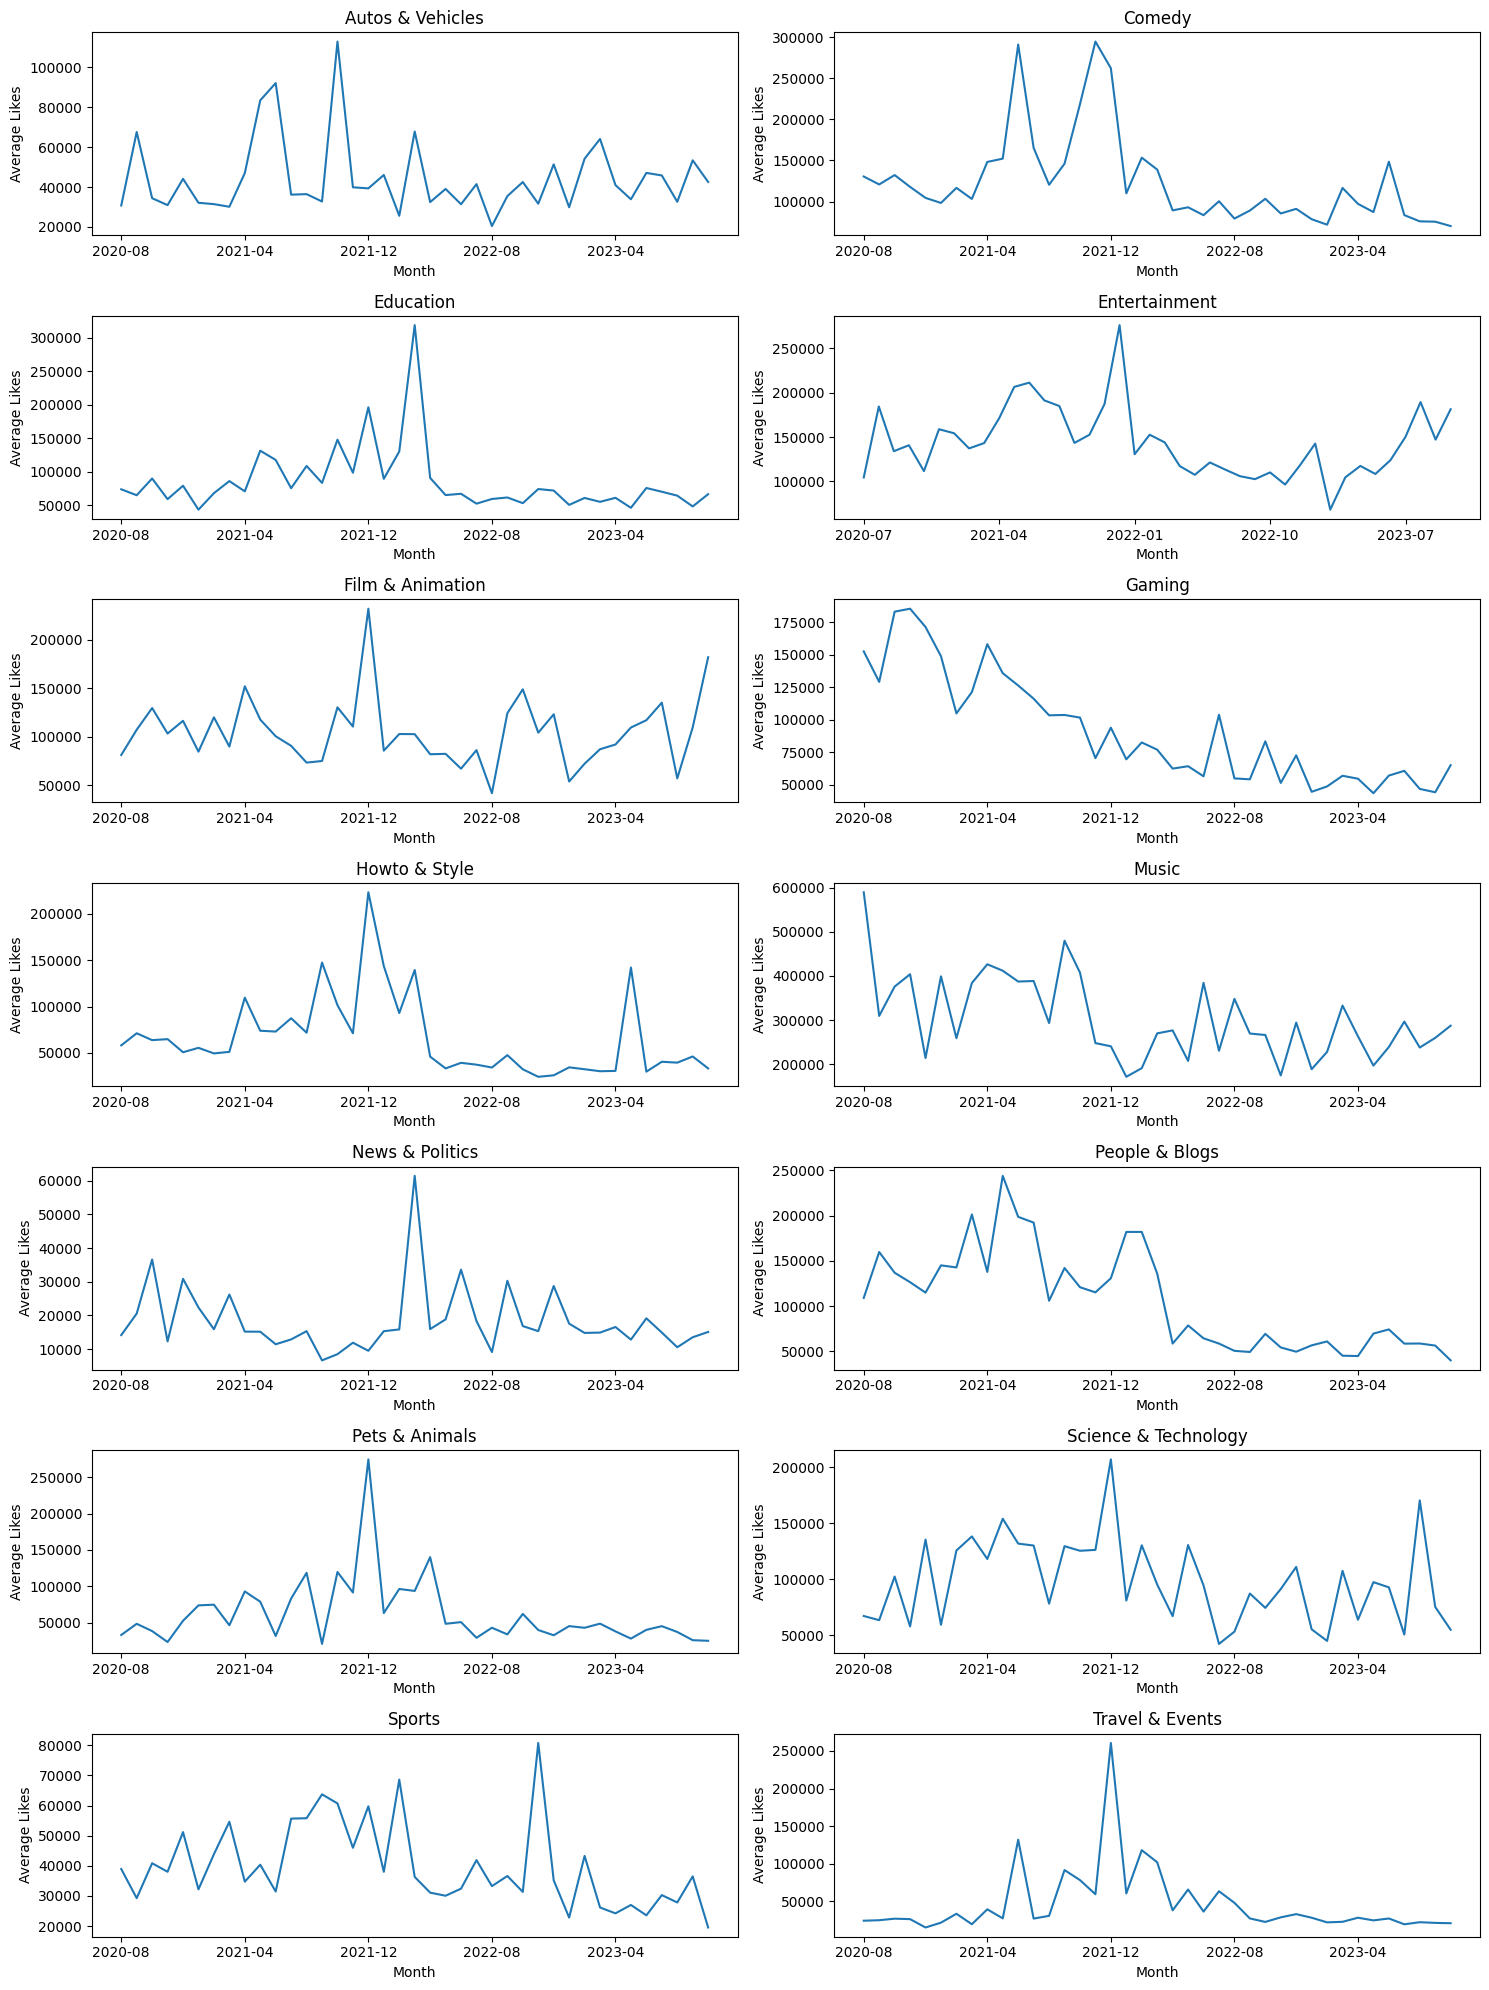

In [ ]:
# 1. 提取每个视频的发布月份
canada_data['month'] = canada_data['publishedAt'].dt.to_period('M')

# 2. 根据`category`和发布月份分组，计算每个类别在每个月的视频的平均点赞量
category_monthly_likes = canada_data.groupby(['category', 'month'])['likes'].mean().reset_index()

# 获取所有的类别
categories = category_monthly_likes['category'].unique()

# 3. 使用matplotlib的子图功能生成一个7*2的图表，并绘制每个类别的趋势
fig, axes = plt.subplots(7, 2, figsize=(15, 20))
axes = axes.ravel()  # flatten the 7x2 matrix of axes

for i, category in enumerate(categories):
    ax = axes[i]
    data = category_monthly_likes[category_monthly_likes['category'] == category]
    ax.plot(data['month'].astype(str), data['likes'])
    ax.set_title(category)
    ax.set_xticks(data['month'].astype(str)[::int(len(data)/5) + 1])  # 限制x轴的标签数量
    ax.set_ylabel('Average Likes')
    ax.set_xlabel('Month')

plt.tight_layout()
plt.show()

In [ ]:
canada_data['score'] = canada_data['likes'] / (canada_data['dislikes'] + canada_data['likes'])
canada_data['month'] = canada_data['trending_date'].dt.to_period('M')
monthly_avg = canada_data.groupby(['video_id', 'month'])['score'].mean().reset_index()
pivot_monthly_avg = monthly_avg.pivot(index='video_id', columns='month', values='score')


# 创建一个pivot table，每行是一个video_id，每列是一个月份，值是情感得分
pivot_monthly_avg = monthly_avg.pivot(index='video_id', columns='month', values='score')

# 将缺失值填充为0
pivot_monthly_avg = pivot_monthly_avg.fillna(0)

# 将dataframe转化为time series格式并进行缩放
X = TimeSeriesScalerMeanVariance().fit_transform(pivot_monthly_avg.values)

# 使用KMeans聚类
model = TimeSeriesKMeans(n_clusters=3, metric="dtw", verbose=True)
labels = model.fit_predict(X)

# 将聚类结果附加到原始数据上
pivot_monthly_avg['cluster'] = labels

<ipython-input-23-bd47d877bd59>:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  canada_data['month'] = canada_data['trending_date'].dt.to_period('M')
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    0.5s

1.862 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    0.7s
[Parallel(

1.282 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    0.7s
[Parallel(

0.979 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    0.9s
[Parallel(

0.971 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    0.7s
[Parallel(

0.971 --> 


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    0.7s
[Parallel(

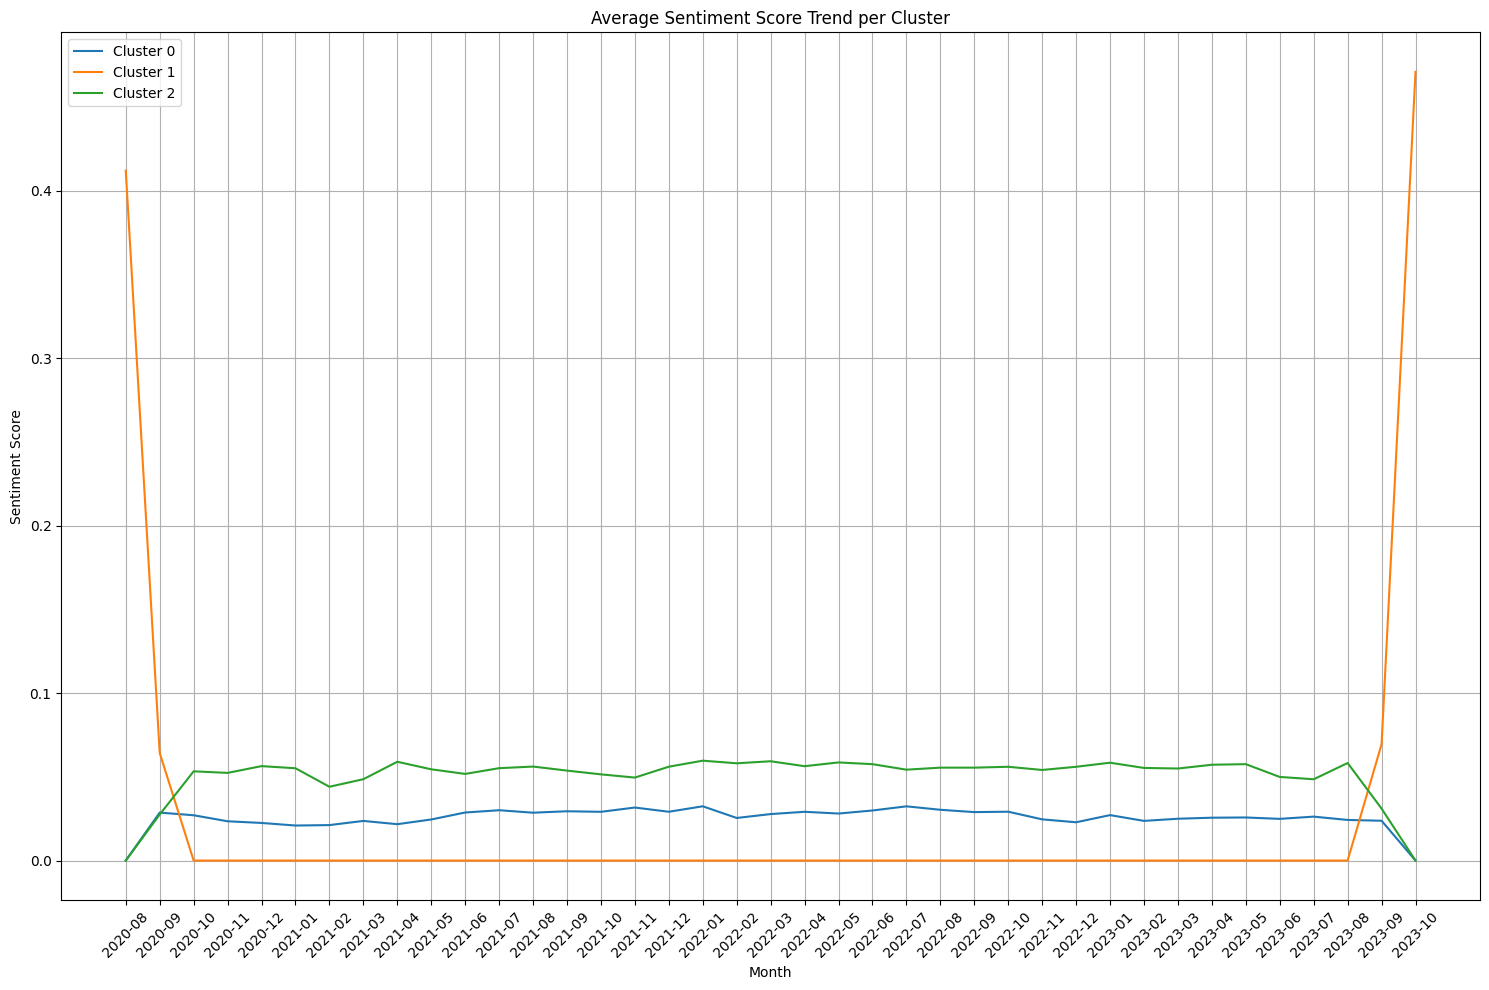

In [ ]:
# 将聚类结果附加到原始数据上
pivot_monthly_avg['cluster'] = labels
# 创建一个新的DataFrame来保存每个聚类的平均情感得分
clustered_avg = pivot_monthly_avg.groupby('cluster').mean()

# 修改这一行，将Period对象转为字符串
plt.figure(figsize=(15, 10))

for cluster in clustered_avg.index:
    plt.plot(clustered_avg.columns.astype(str), clustered_avg.loc[cluster], label=f"Cluster {cluster}")

plt.title("Average Sentiment Score Trend per Cluster")
plt.xlabel("Month")
plt.ylabel("Sentiment Score")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # 旋转x轴标签以提高可读性
plt.tight_layout()
plt.show()
